In [77]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [79]:
def transform(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = transforms.ToTensor()(img)
    return tensor

# Pobranie danych
trainigSet = torchvision.datasets.ImageFolder(
    root='data/Models/Train',
    transform=transform
)

tesingSet = torchvision.datasets.ImageFolder(
    root='data/Models/Test',
    transform=transform
)

batch=100
# Ładowanie danych
trainLoader = DataLoader(trainigSet, batch_size=batch, shuffle=True)
testLoader = DataLoader(tesingSet, batch_size=batch, shuffle=True)

In [80]:
print(trainigSet.class_to_idx)
classes = ('Cab', 'Convertible', 'Coupe', 'Hatchback', 'Minivan', 'SUV', 'Sedan', 'Van')
print(classes)

{'Cab': 0, 'Convertible': 1, 'Coupe': 2, 'Hatchback': 3, 'Minivan': 4, 'SUV': 5, 'Sedan': 6, 'Van': 7}
('Cab', 'Convertible', 'Coupe', 'Hatchback', 'Minivan', 'SUV', 'Sedan', 'Van')


In [81]:
from torch import nn
import numpy as np

class TransferFeatures(nn.Module):
    def __init__(self, pretrainedModel, classifier):
        super(TransferFeatures, self).__init__()

        print(pretrainedModel)
        self.features = pretrainedModel.features
        self.classifier = classifier

        # Freeze those weights
        #for p in self.features.parameters():
        #    p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y

m1 = torchvision.models.alexnet(pretrained=True)

classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 8),
)

model = TransferFeatures(m1, classifier)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Starting epoch  1
Starting epoch  2
Starting epoch  3
Starting epoch  4
Starting epoch  5
Starting epoch  6
Starting epoch  7
Starting epoch  8
Starting epoch  9
Starting epoch  10
Starting epoch  11
Starting epoch  12
Starting epoch  13
Starting epoch  14
Starting epoch  15
Starting epoch  16
Starting epoch  17
Starting epoch  18
Starting epoch  19
Starting epoch  20
Starting epoch  21
Starting epoch  22
Starting epoch  23
Starting epoch  24
Starting epoch  25
Starting epoch  26
Starting epoch  27
Starting epoch  28
Starting epoch  29
Starting epoch  30
Starting epoch  31
Starting epoch  32
Starting epoch  33
Starting epoch  34
Starting epoch  35
Starting epoch  36
Starting epoch  37
Starting epoch  38
Starting epoch  39
Starting epoch  40
Finished Training


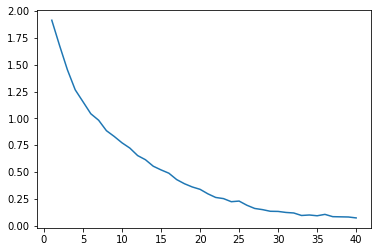

In [82]:
# Trenowanie sieci
noEpochs = 40
prev_epoch = 1
loss_vals=  []
for epoch in range(noEpochs):

    epoch_loss= []
    print("Starting epoch ", epoch + 1)

    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))

torch.save(model, 'carsModel.pth')
print('Finished Training')

plt.plot(np.linspace(1, noEpochs, noEpochs).astype(int), loss_vals)

[[ 9  0  0  0  0  0  0  0]
 [ 0  6  1  0  0  0  0  0]
 [ 0  1  5  0  0  0  1  0]
 [ 0  0  0  1  0  0  5  0]
 [ 0  0  0  0  4  1  0  0]
 [ 0  1  0  1  0 11  0  0]
 [ 0  0  2  0  1  0 19  0]
 [ 1  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.75      0.86      0.80         7
           2       0.62      0.71      0.67         7
           3       0.50      0.17      0.25         6
           4       0.80      0.80      0.80         5
           5       0.92      0.85      0.88        13
           6       0.76      0.86      0.81        22
           7       1.00      0.67      0.80         3

    accuracy                           0.79        72
   macro avg       0.78      0.74      0.74        72
weighted avg       0.78      0.79      0.78        72



<AxesSubplot:>

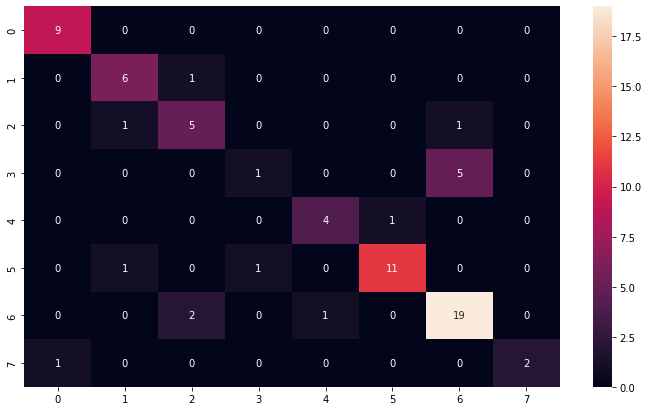

In [97]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

model = torch.load('carsModel.pth')

model.eval()
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')

for i, data in enumerate(testLoader, 0):
    inputs, labels = data
    
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))


print(confusion_matrix(y_trues,
                       y_preds))


print(classification_report(y_trues,
                            y_preds))

plt.figure(figsize = (12,7))
sn.heatmap(confusion_matrix(y_trues, y_preds), annot=True)

[[ 8  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0]
 [ 0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00         7

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



<AxesSubplot:>

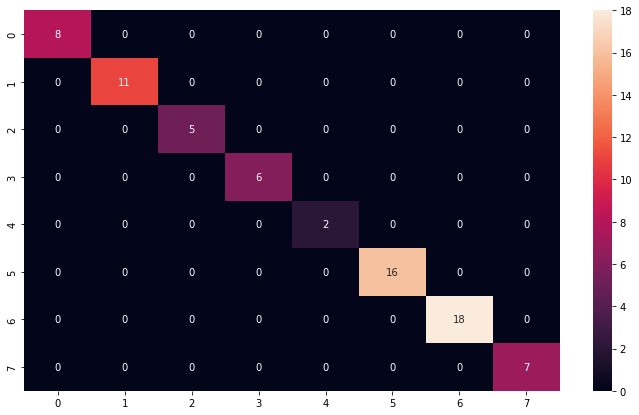

In [95]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

model = torch.load('carsModel.pth')

model.eval()
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')

for i, data in enumerate(trainLoader, 0):
    inputs, labels = data
    
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))


print(confusion_matrix(y_trues,
                       y_preds))


print(classification_report(y_trues,
                            y_preds))

plt.figure(figsize = (12,7))
sn.heatmap(confusion_matrix(y_trues, y_preds), annot=True)

In [86]:
classesDict = str(trainigSet.class_to_idx).split(',')
for i in classesDict:
    print(i)

{'Cab': 0
 'Convertible': 1
 'Coupe': 2
 'Hatchback': 3
 'Minivan': 4
 'SUV': 5
 'Sedan': 6
 'Van': 7}


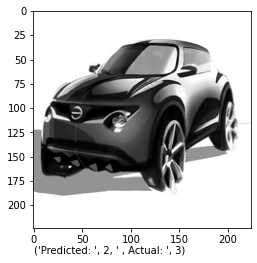

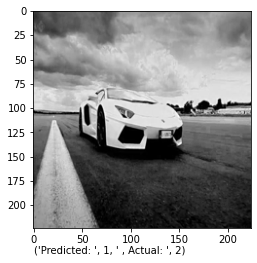

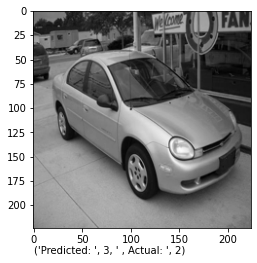

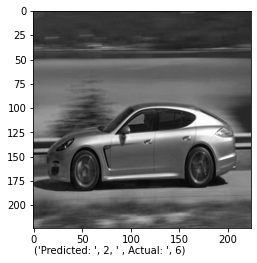

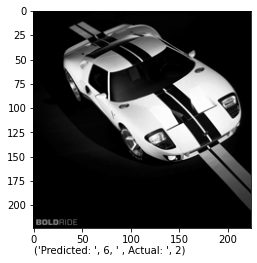

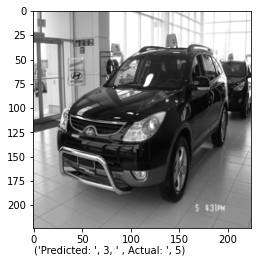

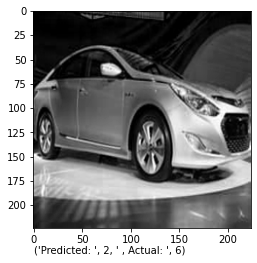

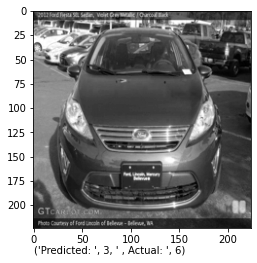

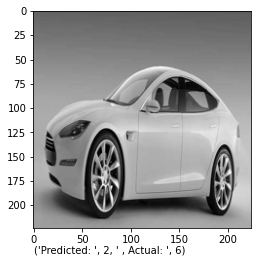

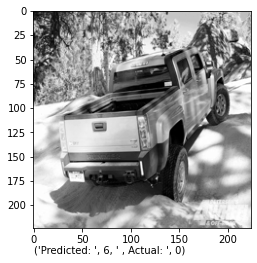

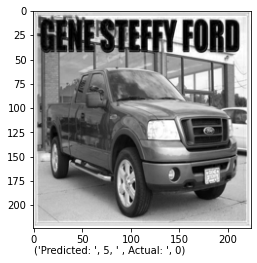

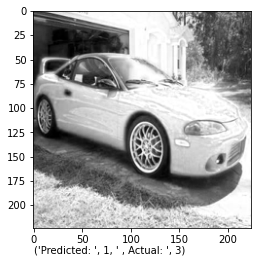

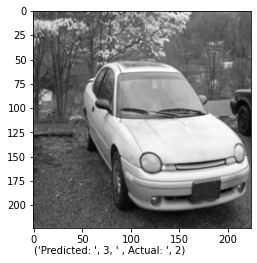

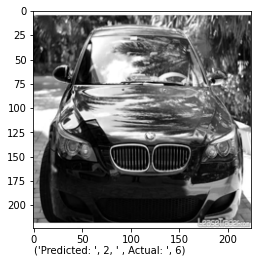

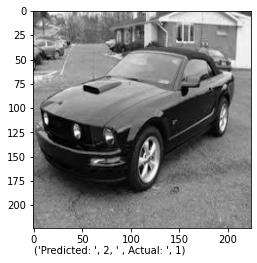

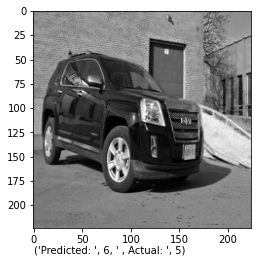

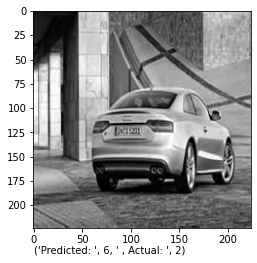

In [98]:
model = torch.load('carsModel.pth')

j = 0

pred = []
act = []
# Przykłady złej klasyfikacji
for i, (samples, labels) in enumerate(testLoader):

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

    if output[j] != labels[j]:
        text = 'Predicted: ', output[j], ' , Actual: ', labels[j]

        img = samples[j][0]

        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.text(0, 250, text)

    j+=1
    if (j >= 4):
        j = 0